###### Measurements from your new thermometer.

In [16]:
import torch

1. Choosing Data

In [17]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] 
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [18]:
t_c.shape

torch.Size([11])

2. Choosing a linear model as a first try

The two sets
 may be linearly related. That is, multiplying t_u by a factor and adding a constant, you
 may get the temperature in Celsius:

>> t_c = w * t_u + b 

Is this assumption reasonable? Probably; you’ll see how well the final model performs.
 (You chose to name w and b after weight and bias, two common terms for linear scaling
 and the additive constant, which you’ll bump into all the time.)

 you need to estimate those parameters so that the error between predicted outputs and measured values is as low as possible. You notice that you still need to define
 a measure of such error. Such measure, which we refer to as the loss function, should
 be high if the error is high and should ideally be as low as possible for a perfect match.
 

Your optimization process, therefore, should aim at finding w and b so that the loss
 function is at a minimum level.

##### Target:
Less loss is what you want.

A loss function (or cost function) is a function that computes a single numerical value
 that the learning process attempts to minimize

 The calculation of loss typically
 involves taking the difference between the desired outputs for some training samples
 and those produced by the model when fed those samples—in this case, the difference between the predicted temperatures t_p output by the model and the actual
 measurements, so t_p - t_c. 

##### Note:
 You need to make sure the loss function makes the loss positive both when t_p is
 above and when below the true t_c, because the goal is to minimize this value. (Being
 able to push the loss infinitely negative isn’t useful.) You have a few choices, the most
 straightforward being
 * |t_p - t_c| 
 * (t_p - t_c)^2

##### Note: 
It’s worth noting that the square difference also penalizes wildly wrong results more
 than the absolute difference. Often, having more slightly wrong results is better than
 having a few wildly wrong ones, and the squared difference helps prioritize those
 results as desired

2. Write the model as a Python Function

In [19]:
def model(t_u, w, b):  
    return w * t_u + b

3. Define loss:
> * The loss is a mean square loss.

In [20]:
def loss_fn(t_p, t_c):  
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

4.  initialize the parameters

In [21]:
w = torch.ones(1)
b = torch.zeros(1)

In [22]:
# invoke model
t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [23]:
# check loss
loss = loss_fn(t_p, t_c) 
loss

tensor(1763.8846)

###### Summary: 
In this topic we implemented the model and the loss. 
##### Goal:
how to estimate the w and b such that the loss reaches a minimum. 

### Optimize:
In this section we will see how can we update w and b, to minimize the loss function. 

>  optimize the loss function with respect to the parameters by using
 the so-called gradient descent algorithm
 
 Gradient descent is a simple idea that scales up
 surprisingly well to large neural network models with millions of parameters. 
 
 The idea is to compute the rate of change of the
 loss with respect to each parameter and apply a change to each parameter in the
 direction of decreasing loss.

In [24]:
# check how much change in w results in change in loss
delta = 0.1
loss_rate_of_change_w = (loss_fn(model(t_u, w + delta, b), t_c)-
                         loss_fn(model(t_u, w - delta, b), t_c))/ (2.0 * delta) 

In [25]:
loss_rate_of_change_w # 0.2 (0.1 in one side) total change in weight 
# results 

tensor(4517.2979)

In [26]:
# if delta is doubled
# check how much change in w results in change in loss
delta = 0.2
loss_rate_of_change_w = (loss_fn(model(t_u, w + delta, b), t_c)-
                         loss_fn(model(t_u, w - delta, b), t_c))/ (2.0 * delta) 

In [27]:
loss_rate_of_change_w

tensor(4517.2974)

##### Analysis:
This code is saying that in a small neighborhood of the current values of w and b, a
 unit increase in w leads to some change in the loss. If the change is negative, you need
 to increase w to minimize the loss, whereas if the change is positive, you need to
 decrease w. 

 By how much? Applying a change to w that’s proportional to the rate of
 change of the loss is a good idea, especially when the loss has several parameters:
 you’d apply a change to those that exert a significant change on the loss. 

  ###### Note:
    It’s also wise to change the parameters slowly in general, because the rate of change could be dramatically different at a distance 
    from the neighborhood of the current w value. Therefore, you 
    should scale the rate of change by a typically small factor. This scaling factor has many names; the one used in machine learning is 
    learning_rate.


In [28]:
# by using learning rate 
learning_rate = 1e-2
# with proportion to loss function we change weights 
w = w - learning_rate * loss_rate_of_change_w 
w

tensor([-44.1730])

In [29]:
# You can do the same with b:
loss_rate_of_change_b = (loss_fn(model(t_u, w, b + delta), t_c)-
                         loss_fn(model(t_u, w, b - delta), t_c))/ (2.0 * delta)

In [30]:
b = b - learning_rate * loss_rate_of_change_b
b

tensor([45.9375])

##### Summary:
This code represents the basic parameter update step for gradient descent. By reiterating these evaluations (provided that you choose a small-enough learning rate),
 you’d converge to an optimal value of the parameters for which the loss computed on
 the given data is minimal. 
 
 But this
 method of computing rates of change is rather crude and needs an upgrade. 

 ###### > Getting analytical:

Computing the rate of change by using repeated evaluations of model and loss to
 probe the behavior of the loss function in the neighborhood of w and b doesn’t scale
 well to models with many parameters. Also, it isn’t always clear how large that neighborhood should be.

 You chose delta equal to 0.1 earlier, but everything depends on
 the shape of the loss as a function of w and b. If the loss changes too quickly compared
 with delta, you won’t have a good idea of where downhill is. 

To compute the derivative of the loss with respect to a parameter, you can apply the
 chain rule and compute the derivative of the loss with respect to its input (which is the
 output of the model) times the derivative of the model with respect to the parameter:

d loss_fn / d w = (d loss_fn / d t_p) * (d t_p / d w) 

Recall that the model is a linear function and the loss is a sum of squares. Now figure
 out the expressions for the derivatives. Recalling the expression for the loss


In [31]:
# rewrite the function 
def loss_fn(t_p, t_c):   
    squared_diffs = (t_p - t_c)**2  
    return squared_diffs.mean()

> Recall derivative: d x^2 / d x = 2 x, you get

In [32]:
# dloss_fn/dt_p
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) 
    return dsq_diffs

In [33]:
# As for the model, recalling that the model is

def model(t_u, w, b): 
    return w * t_u + b

In [34]:
# dt_p/dw
def dmodel_dw(tu,w,b):
    # dmod = t_u
    return t_u
# dt_p/db
def dmodel_db(t_u, w, b):  
    return 1.

Putting all this together, the function that returns the gradient of the loss with respect
 to w and b is:


In [35]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dw = dloss_fn(t_p, t_c) * dmodel_dw(t_u, w, b) 
    dloss_db = dloss_fn(t_p, t_c) * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.mean(), dloss_db.mean()])

###### The training loop:

Now you have everything in place to optimize your parameters. Starting from a tentative value for a parameter, you can iteratively apply updates to it for a fixed number of
 iterations or until w and b stop changing. You can use several stopping criteria, but
 stick to a fixed number of iterations for now.

> A training
 iteration during which you update the parameters for all your training samples is
 called an epoch.

 The complete training loop looks like this:


In [52]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c,
                  print_params=True): 
    for epoch in range(1, n_epochs + 1):        
        w, b = params
        t_p = model(t_u, w, b)          
        loss = loss_fn(t_p, t_c)        
        grad = grad_fn(t_u, t_c, t_p, w, b) 
        params = params - learning_rate * grad
        print('Epoch %d, Loss %f' % (epoch, float(loss)))
        if print_params:        
            print('    Params:', params)
            print('    Grad:  ', grad)
    return params

Now invoke your training loop:


In [40]:
training_loop(n_epochs = 100, learning_rate = 1e-2,
              params = torch.tensor([1.0, 0.0]),
              t_u=t_u,  
              t_c=t_c)

Epoch 1, Loss 1763.884644
Epoch 2, Loss 5802484.500000
Epoch 3, Loss 19408031744.000000
Epoch 4, Loss 64915909902336.000000
Epoch 5, Loss 217130439561707520.000000
Epoch 6, Loss 726257020202974707712.000000
Epoch 7, Loss 2429181687085405986357248.000000
Epoch 8, Loss 8125117236949438203699396608.000000
Epoch 9, Loss 27176865195881116022129584766976.000000
Epoch 10, Loss 90901075478458130961171361977860096.000000
Epoch 11, Loss inf
Epoch 12, Loss inf
Epoch 13, Loss inf
Epoch 14, Loss inf
Epoch 15, Loss inf
Epoch 16, Loss inf
Epoch 17, Loss inf
Epoch 18, Loss inf
Epoch 19, Loss inf
Epoch 20, Loss inf
Epoch 21, Loss inf
Epoch 22, Loss inf
Epoch 23, Loss nan
Epoch 24, Loss nan
Epoch 25, Loss nan
Epoch 26, Loss nan
Epoch 27, Loss nan
Epoch 28, Loss nan
Epoch 29, Loss nan
Epoch 30, Loss nan
Epoch 31, Loss nan
Epoch 32, Loss nan
Epoch 33, Loss nan
Epoch 34, Loss nan
Epoch 35, Loss nan
Epoch 36, Loss nan
Epoch 37, Loss nan
Epoch 38, Loss nan
Epoch 39, Loss nan
Epoch 40, Loss nan
Epoch 41, Loss

tensor([nan, nan])

##### Note:
 Your training process blew up, leading to losses becoming inf. This result is a clear sign that params is receiving updates that are too large; their values start oscillating back and forth as each update overshoots, and the next overcorrects even more. The optimization process is unstable; it diverges instead of converging
 to a minimum. You want to see smaller and smaller updates to params, not larger,

How can you limit the magnitude of the learning_rate * grad? Well, that process
 looks easy. You could simply choose a smaller learning_rate. 

 You usually change learning rates by order of magnitude, so you might try 1e-3 or 1e-4, which would decrease
 the magnitude of updates by orders of magnitude. Go with 1e-4 to see how it works out:


In [44]:
training_loop(n_epochs = 100, learning_rate = 1e-4,
              params = torch.tensor([1.0, 0.0]),
              t_u=t_u,  
              t_c=t_c)

Epoch 1, Loss 1763.884644
    Params: tensor([ 0.5483, -0.0083])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 323.090546
    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4666,  16.5122])
Epoch 4, Loss 37.552845
    Params: tensor([ 0.2543, -0.0143])
    Grad:   tensor([315.0790,   8.5787])
Epoch 5, Loss 30.540285
    Params: tensor([ 0.2413, -0.0149])
    Grad:   tensor([129.6733,   5.3127])
Epoch 6, Loss 29.351152
    Params: tensor([ 0.2360, -0.0153])
    Grad:   tensor([53.3496,  3.9682])
Epoch 7, Loss 29.148882
    Params: tensor([ 0.2338, -0.0156])
    Grad:   tensor([21.9304,  3.4148])
Epoch 8, Loss 29.113848
    Params: tensor([ 0.2329, -0.0159])
    Grad:   tensor([8.9964, 3.1869])
Epoch 9, Loss 29.107145
    Params: tensor([ 0.2325, -0.0162])
    Grad:   tensor([3.6721, 3.0930])
Epoch 10, Loss 29.105242
    Params: tensor([ 0.2324, -0.0166])
    G

tensor([ 0.2327, -0.0438])

 The behavior is stable now. 
 
 But there’s another problem: 
 
 * updates to parameters are small, so the loss decreases slowly and eventually stalls. You could obviate this issue by making the learning_rate adaptive—that is, change according to the magnitude of updates. 

> You can use several optimization schemes for that purpose; you see one  “Optimizers a-la Carte”

* Another potential troublemaker exists in the update term: the gradient itself. Go back to look at grad at epoch 1 during optimization. You see that the first-epoch gradient for the weight is about 50 times larger than the gradient for the bias, so the weight and bias live in differently scaled spaces. 

>  In this case, a learning rate that’s large
 enough to meaningfully update one is so large that it’s unstable for the other, or a rate
 that’s appropriate for the second one won’t be large enough to change the first meaningfully. You’re not going to be able to update your parameters unless you change
 your formulation of the problem. You could have individual learning rates for each
 parameter, but for models with many parameters, this approach would be too much to
 bother with.
 
 You have a simpler way to keep things in check: change the inputs so that the gradients aren’t so different. You can make sure that the range of the input doesn’t get
 too far from the range of -1.0 to 1.0, roughly speaking. In this case, you can achieve
 something close enough to that example by multiplying t_u by 0.1:

In [50]:
t_un = 0.01 * t_u 

Here, you denote the normalized version of t_u by appending n to the variable name.
 At this point, you can run the training loop on your normalized input:


In [51]:
training_loop(n_epochs = 100, learning_rate = 1e-2, 
              params = torch.tensor([1.0, 0.0]),
              t_u = t_un, # now use the normalized input 
              t_c = t_c) 

Epoch 1, Loss 174.037460
    Params: tensor([14.0548,  0.1996])
    Grad:   tensor([-1305.4841,   -19.9640])
Epoch 2, Loss 52.482601
    Params: tensor([19.2245,  0.2600])
    Grad:   tensor([-516.9683,   -6.0399])
Epoch 3, Loss 33.578781
    Params: tensor([21.2910,  0.2657])
    Grad:   tensor([-206.6511,   -0.5633])
Epoch 4, Loss 30.573090
    Params: tensor([22.1363,  0.2498])
    Grad:   tensor([-84.5237,   1.5889])
Epoch 5, Loss 30.029854
    Params: tensor([22.5008,  0.2255])
    Grad:   tensor([-36.4562,   2.4327])
Epoch 6, Loss 29.868258
    Params: tensor([22.6762,  0.1978])
    Grad:   tensor([-17.5344,   2.7618])
Epoch 7, Loss 29.766027
    Params: tensor([22.7770,  0.1690])
    Grad:   tensor([-10.0826,   2.8882])
Epoch 8, Loss 29.673250
    Params: tensor([22.8485,  0.1396])
    Grad:   tensor([-7.1445,  2.9349])
Epoch 9, Loss 29.582197
    Params: tensor([22.9083,  0.1101])
    Grad:   tensor([-5.9830,  2.9502])
Epoch 10, Loss 29.491674
    Params: tensor([22.9635,  0.08

tensor([27.3230, -2.3861])

Even though you set your learning rate back to 1e-2, parameters didn’t blow up
 during iterative updates. Now take a look at the gradients; they were of similar magnitudes, so using a single learning_rate for both parameters worked fine. You probably
 could do a better job of normalization than rescaling by a factor of ten, but because
 doing so is good enough for your needs.


##### NOTE:
The normalization here helps you get the network trained, but you
 could make an argument that it’s not strictly needed to optimize the parameters for this problem. That’s absolutely true! This problem is small enough
 that you have numerous ways to beat the parameters into submission. For
 larger, more sophisticated problems, however, normalization is an easy and
 effective (if not crucial!) tool to use to improve model convergence.

Next, run the loop for enough iterations to see the changes in params get small.
 Change n_epochs to 5000:


In [53]:
params = training_loop(n_epochs = 5000,learning_rate = 1e-2, 
                       params = torch.tensor([1.0, 0.0]),
                       t_u = t_un,
                       t_c = t_c,    
                       print_params = False)

Epoch 1, Loss 174.037460
Epoch 2, Loss 52.482601
Epoch 3, Loss 33.578781
Epoch 4, Loss 30.573090
Epoch 5, Loss 30.029854
Epoch 6, Loss 29.868258
Epoch 7, Loss 29.766027
Epoch 8, Loss 29.673250
Epoch 9, Loss 29.582197
Epoch 10, Loss 29.491674
Epoch 11, Loss 29.401491
Epoch 12, Loss 29.311626
Epoch 13, Loss 29.222059
Epoch 14, Loss 29.132805
Epoch 15, Loss 29.043842
Epoch 16, Loss 28.955189
Epoch 17, Loss 28.866838
Epoch 18, Loss 28.778784
Epoch 19, Loss 28.691029
Epoch 20, Loss 28.603569
Epoch 21, Loss 28.516411
Epoch 22, Loss 28.429543
Epoch 23, Loss 28.342970
Epoch 24, Loss 28.256695
Epoch 25, Loss 28.170713
Epoch 26, Loss 28.085022
Epoch 27, Loss 27.999628
Epoch 28, Loss 27.914515
Epoch 29, Loss 27.829689
Epoch 30, Loss 27.745155
Epoch 31, Loss 27.660913
Epoch 32, Loss 27.576952
Epoch 33, Loss 27.493275
Epoch 34, Loss 27.409883
Epoch 35, Loss 27.326782
Epoch 36, Loss 27.243950
Epoch 37, Loss 27.161406
Epoch 38, Loss 27.079138
Epoch 39, Loss 26.997150
Epoch 40, Loss 26.915443
Epoch 41

Epoch 550, Loss 7.162435
Epoch 551, Loss 7.148057
Epoch 552, Loss 7.133732
Epoch 553, Loss 7.119452
Epoch 554, Loss 7.105221
Epoch 555, Loss 7.091042
Epoch 556, Loss 7.076909
Epoch 557, Loss 7.062825
Epoch 558, Loss 7.048787
Epoch 559, Loss 7.034799
Epoch 560, Loss 7.020857
Epoch 561, Loss 7.006959
Epoch 562, Loss 6.993113
Epoch 563, Loss 6.979312
Epoch 564, Loss 6.965558
Epoch 565, Loss 6.951850
Epoch 566, Loss 6.938190
Epoch 567, Loss 6.924577
Epoch 568, Loss 6.911005
Epoch 569, Loss 6.897484
Epoch 570, Loss 6.884007
Epoch 571, Loss 6.870577
Epoch 572, Loss 6.857191
Epoch 573, Loss 6.843853
Epoch 574, Loss 6.830561
Epoch 575, Loss 6.817310
Epoch 576, Loss 6.804108
Epoch 577, Loss 6.790947
Epoch 578, Loss 6.777833
Epoch 579, Loss 6.764765
Epoch 580, Loss 6.751737
Epoch 581, Loss 6.738756
Epoch 582, Loss 6.725819
Epoch 583, Loss 6.712925
Epoch 584, Loss 6.700075
Epoch 585, Loss 6.687270
Epoch 586, Loss 6.674507
Epoch 587, Loss 6.661788
Epoch 588, Loss 6.649111
Epoch 589, Loss 6.636477


Epoch 1052, Loss 3.695871
Epoch 1053, Loss 3.693261
Epoch 1054, Loss 3.690663
Epoch 1055, Loss 3.688074
Epoch 1056, Loss 3.685491
Epoch 1057, Loss 3.682919
Epoch 1058, Loss 3.680355
Epoch 1059, Loss 3.677798
Epoch 1060, Loss 3.675255
Epoch 1061, Loss 3.672715
Epoch 1062, Loss 3.670185
Epoch 1063, Loss 3.667667
Epoch 1064, Loss 3.665153
Epoch 1065, Loss 3.662650
Epoch 1066, Loss 3.660156
Epoch 1067, Loss 3.657667
Epoch 1068, Loss 3.655189
Epoch 1069, Loss 3.652721
Epoch 1070, Loss 3.650259
Epoch 1071, Loss 3.647806
Epoch 1072, Loss 3.645363
Epoch 1073, Loss 3.642924
Epoch 1074, Loss 3.640497
Epoch 1075, Loss 3.638075
Epoch 1076, Loss 3.635667
Epoch 1077, Loss 3.633263
Epoch 1078, Loss 3.630867
Epoch 1079, Loss 3.628479
Epoch 1080, Loss 3.626100
Epoch 1081, Loss 3.623731
Epoch 1082, Loss 3.621365
Epoch 1083, Loss 3.619010
Epoch 1084, Loss 3.616666
Epoch 1085, Loss 3.614327
Epoch 1086, Loss 3.611994
Epoch 1087, Loss 3.609669
Epoch 1088, Loss 3.607356
Epoch 1089, Loss 3.605048
Epoch 1090, 

Epoch 1660, Loss 3.024830
Epoch 1661, Loss 3.024500
Epoch 1662, Loss 3.024172
Epoch 1663, Loss 3.023841
Epoch 1664, Loss 3.023517
Epoch 1665, Loss 3.023191
Epoch 1666, Loss 3.022866
Epoch 1667, Loss 3.022544
Epoch 1668, Loss 3.022222
Epoch 1669, Loss 3.021901
Epoch 1670, Loss 3.021581
Epoch 1671, Loss 3.021261
Epoch 1672, Loss 3.020943
Epoch 1673, Loss 3.020626
Epoch 1674, Loss 3.020311
Epoch 1675, Loss 3.019997
Epoch 1676, Loss 3.019683
Epoch 1677, Loss 3.019371
Epoch 1678, Loss 3.019060
Epoch 1679, Loss 3.018749
Epoch 1680, Loss 3.018440
Epoch 1681, Loss 3.018132
Epoch 1682, Loss 3.017824
Epoch 1683, Loss 3.017518
Epoch 1684, Loss 3.017213
Epoch 1685, Loss 3.016910
Epoch 1686, Loss 3.016606
Epoch 1687, Loss 3.016305
Epoch 1688, Loss 3.016003
Epoch 1689, Loss 3.015703
Epoch 1690, Loss 3.015404
Epoch 1691, Loss 3.015108
Epoch 1692, Loss 3.014809
Epoch 1693, Loss 3.014514
Epoch 1694, Loss 3.014219
Epoch 1695, Loss 3.013925
Epoch 1696, Loss 3.013631
Epoch 1697, Loss 3.013339
Epoch 1698, 

Epoch 2021, Loss 2.956119
Epoch 2022, Loss 2.956023
Epoch 2023, Loss 2.955926
Epoch 2024, Loss 2.955830
Epoch 2025, Loss 2.955735
Epoch 2026, Loss 2.955638
Epoch 2027, Loss 2.955544
Epoch 2028, Loss 2.955449
Epoch 2029, Loss 2.955354
Epoch 2030, Loss 2.955261
Epoch 2031, Loss 2.955168
Epoch 2032, Loss 2.955073
Epoch 2033, Loss 2.954982
Epoch 2034, Loss 2.954888
Epoch 2035, Loss 2.954797
Epoch 2036, Loss 2.954704
Epoch 2037, Loss 2.954612
Epoch 2038, Loss 2.954520
Epoch 2039, Loss 2.954429
Epoch 2040, Loss 2.954337
Epoch 2041, Loss 2.954247
Epoch 2042, Loss 2.954158
Epoch 2043, Loss 2.954066
Epoch 2044, Loss 2.953976
Epoch 2045, Loss 2.953888
Epoch 2046, Loss 2.953797
Epoch 2047, Loss 2.953708
Epoch 2048, Loss 2.953621
Epoch 2049, Loss 2.953534
Epoch 2050, Loss 2.953445
Epoch 2051, Loss 2.953357
Epoch 2052, Loss 2.953270
Epoch 2053, Loss 2.953184
Epoch 2054, Loss 2.953096
Epoch 2055, Loss 2.953010
Epoch 2056, Loss 2.952925
Epoch 2057, Loss 2.952839
Epoch 2058, Loss 2.952753
Epoch 2059, 

Epoch 2572, Loss 2.932017
Epoch 2573, Loss 2.932001
Epoch 2574, Loss 2.931987
Epoch 2575, Loss 2.931970
Epoch 2576, Loss 2.931957
Epoch 2577, Loss 2.931943
Epoch 2578, Loss 2.931928
Epoch 2579, Loss 2.931913
Epoch 2580, Loss 2.931899
Epoch 2581, Loss 2.931885
Epoch 2582, Loss 2.931869
Epoch 2583, Loss 2.931857
Epoch 2584, Loss 2.931840
Epoch 2585, Loss 2.931827
Epoch 2586, Loss 2.931813
Epoch 2587, Loss 2.931798
Epoch 2588, Loss 2.931783
Epoch 2589, Loss 2.931770
Epoch 2590, Loss 2.931756
Epoch 2591, Loss 2.931743
Epoch 2592, Loss 2.931729
Epoch 2593, Loss 2.931715
Epoch 2594, Loss 2.931699
Epoch 2595, Loss 2.931686
Epoch 2596, Loss 2.931673
Epoch 2597, Loss 2.931660
Epoch 2598, Loss 2.931647
Epoch 2599, Loss 2.931633
Epoch 2600, Loss 2.931619
Epoch 2601, Loss 2.931606
Epoch 2602, Loss 2.931591
Epoch 2603, Loss 2.931578
Epoch 2604, Loss 2.931564
Epoch 2605, Loss 2.931551
Epoch 2606, Loss 2.931539
Epoch 2607, Loss 2.931526
Epoch 2608, Loss 2.931513
Epoch 2609, Loss 2.931499
Epoch 2610, 

Epoch 2902, Loss 2.929066
Epoch 2903, Loss 2.929061
Epoch 2904, Loss 2.929058
Epoch 2905, Loss 2.929053
Epoch 2906, Loss 2.929048
Epoch 2907, Loss 2.929043
Epoch 2908, Loss 2.929039
Epoch 2909, Loss 2.929033
Epoch 2910, Loss 2.929030
Epoch 2911, Loss 2.929025
Epoch 2912, Loss 2.929018
Epoch 2913, Loss 2.929014
Epoch 2914, Loss 2.929010
Epoch 2915, Loss 2.929005
Epoch 2916, Loss 2.929001
Epoch 2917, Loss 2.928995
Epoch 2918, Loss 2.928992
Epoch 2919, Loss 2.928987
Epoch 2920, Loss 2.928982
Epoch 2921, Loss 2.928979
Epoch 2922, Loss 2.928973
Epoch 2923, Loss 2.928969
Epoch 2924, Loss 2.928964
Epoch 2925, Loss 2.928960
Epoch 2926, Loss 2.928957
Epoch 2927, Loss 2.928951
Epoch 2928, Loss 2.928946
Epoch 2929, Loss 2.928944
Epoch 2930, Loss 2.928937
Epoch 2931, Loss 2.928933
Epoch 2932, Loss 2.928928
Epoch 2933, Loss 2.928925
Epoch 2934, Loss 2.928918
Epoch 2935, Loss 2.928914
Epoch 2936, Loss 2.928912
Epoch 2937, Loss 2.928906
Epoch 2938, Loss 2.928903
Epoch 2939, Loss 2.928898
Epoch 2940, 

Epoch 3429, Loss 2.927879
Epoch 3430, Loss 2.927880
Epoch 3431, Loss 2.927879
Epoch 3432, Loss 2.927877
Epoch 3433, Loss 2.927876
Epoch 3434, Loss 2.927876
Epoch 3435, Loss 2.927876
Epoch 3436, Loss 2.927873
Epoch 3437, Loss 2.927874
Epoch 3438, Loss 2.927873
Epoch 3439, Loss 2.927871
Epoch 3440, Loss 2.927873
Epoch 3441, Loss 2.927870
Epoch 3442, Loss 2.927869
Epoch 3443, Loss 2.927869
Epoch 3444, Loss 2.927868
Epoch 3445, Loss 2.927869
Epoch 3446, Loss 2.927867
Epoch 3447, Loss 2.927866
Epoch 3448, Loss 2.927866
Epoch 3449, Loss 2.927866
Epoch 3450, Loss 2.927864
Epoch 3451, Loss 2.927864
Epoch 3452, Loss 2.927863
Epoch 3453, Loss 2.927862
Epoch 3454, Loss 2.927863
Epoch 3455, Loss 2.927861
Epoch 3456, Loss 2.927860
Epoch 3457, Loss 2.927859
Epoch 3458, Loss 2.927858
Epoch 3459, Loss 2.927856
Epoch 3460, Loss 2.927857
Epoch 3461, Loss 2.927856
Epoch 3462, Loss 2.927855
Epoch 3463, Loss 2.927855
Epoch 3464, Loss 2.927855
Epoch 3465, Loss 2.927854
Epoch 3466, Loss 2.927852
Epoch 3467, 

Epoch 4018, Loss 2.927676
Epoch 4019, Loss 2.927674
Epoch 4020, Loss 2.927676
Epoch 4021, Loss 2.927674
Epoch 4022, Loss 2.927675
Epoch 4023, Loss 2.927674
Epoch 4024, Loss 2.927674
Epoch 4025, Loss 2.927673
Epoch 4026, Loss 2.927674
Epoch 4027, Loss 2.927675
Epoch 4028, Loss 2.927674
Epoch 4029, Loss 2.927675
Epoch 4030, Loss 2.927674
Epoch 4031, Loss 2.927674
Epoch 4032, Loss 2.927673
Epoch 4033, Loss 2.927673
Epoch 4034, Loss 2.927674
Epoch 4035, Loss 2.927674
Epoch 4036, Loss 2.927673
Epoch 4037, Loss 2.927672
Epoch 4038, Loss 2.927673
Epoch 4039, Loss 2.927674
Epoch 4040, Loss 2.927672
Epoch 4041, Loss 2.927674
Epoch 4042, Loss 2.927673
Epoch 4043, Loss 2.927672
Epoch 4044, Loss 2.927672
Epoch 4045, Loss 2.927673
Epoch 4046, Loss 2.927673
Epoch 4047, Loss 2.927673
Epoch 4048, Loss 2.927671
Epoch 4049, Loss 2.927672
Epoch 4050, Loss 2.927673
Epoch 4051, Loss 2.927672
Epoch 4052, Loss 2.927672
Epoch 4053, Loss 2.927672
Epoch 4054, Loss 2.927672
Epoch 4055, Loss 2.927672
Epoch 4056, 

Epoch 4666, Loss 2.927647
Epoch 4667, Loss 2.927645
Epoch 4668, Loss 2.927646
Epoch 4669, Loss 2.927647
Epoch 4670, Loss 2.927646
Epoch 4671, Loss 2.927648
Epoch 4672, Loss 2.927647
Epoch 4673, Loss 2.927646
Epoch 4674, Loss 2.927647
Epoch 4675, Loss 2.927648
Epoch 4676, Loss 2.927646
Epoch 4677, Loss 2.927647
Epoch 4678, Loss 2.927645
Epoch 4679, Loss 2.927646
Epoch 4680, Loss 2.927647
Epoch 4681, Loss 2.927647
Epoch 4682, Loss 2.927646
Epoch 4683, Loss 2.927647
Epoch 4684, Loss 2.927646
Epoch 4685, Loss 2.927646
Epoch 4686, Loss 2.927648
Epoch 4687, Loss 2.927647
Epoch 4688, Loss 2.927647
Epoch 4689, Loss 2.927648
Epoch 4690, Loss 2.927648
Epoch 4691, Loss 2.927647
Epoch 4692, Loss 2.927647
Epoch 4693, Loss 2.927646
Epoch 4694, Loss 2.927644
Epoch 4695, Loss 2.927648
Epoch 4696, Loss 2.927646
Epoch 4697, Loss 2.927647
Epoch 4698, Loss 2.927647
Epoch 4699, Loss 2.927646
Epoch 4700, Loss 2.927648
Epoch 4701, Loss 2.927647
Epoch 4702, Loss 2.927648
Epoch 4703, Loss 2.927646
Epoch 4704, 

In [54]:
print(params)

tensor([ 53.6708, -17.3012])


###### Analysis:
You saw the loss decrease while you were changing parameters along the direction of gradient descent. The loss didn’t go to zero, which could mean that iterations
 weren’t enough to converge to zero or that the data points aren’t sitting on a line.  As
 anticipated, your measurements weren’t perfectly accurate or noise was involved in
 the reading.

In [56]:
params*0.01

tensor([ 0.5367, -0.1730])

The first thing that anyone doing data science should do is plot and get an idea of the data.


In [57]:
%matplotlib inline 
from matplotlib import pyplot as plt
t_p = model(t_un, *params)  # using the normalized input to get t_p

In [65]:
#t_p.detach().numpy()

The plot of your linear-fit model (solid line) versus input data (circles)


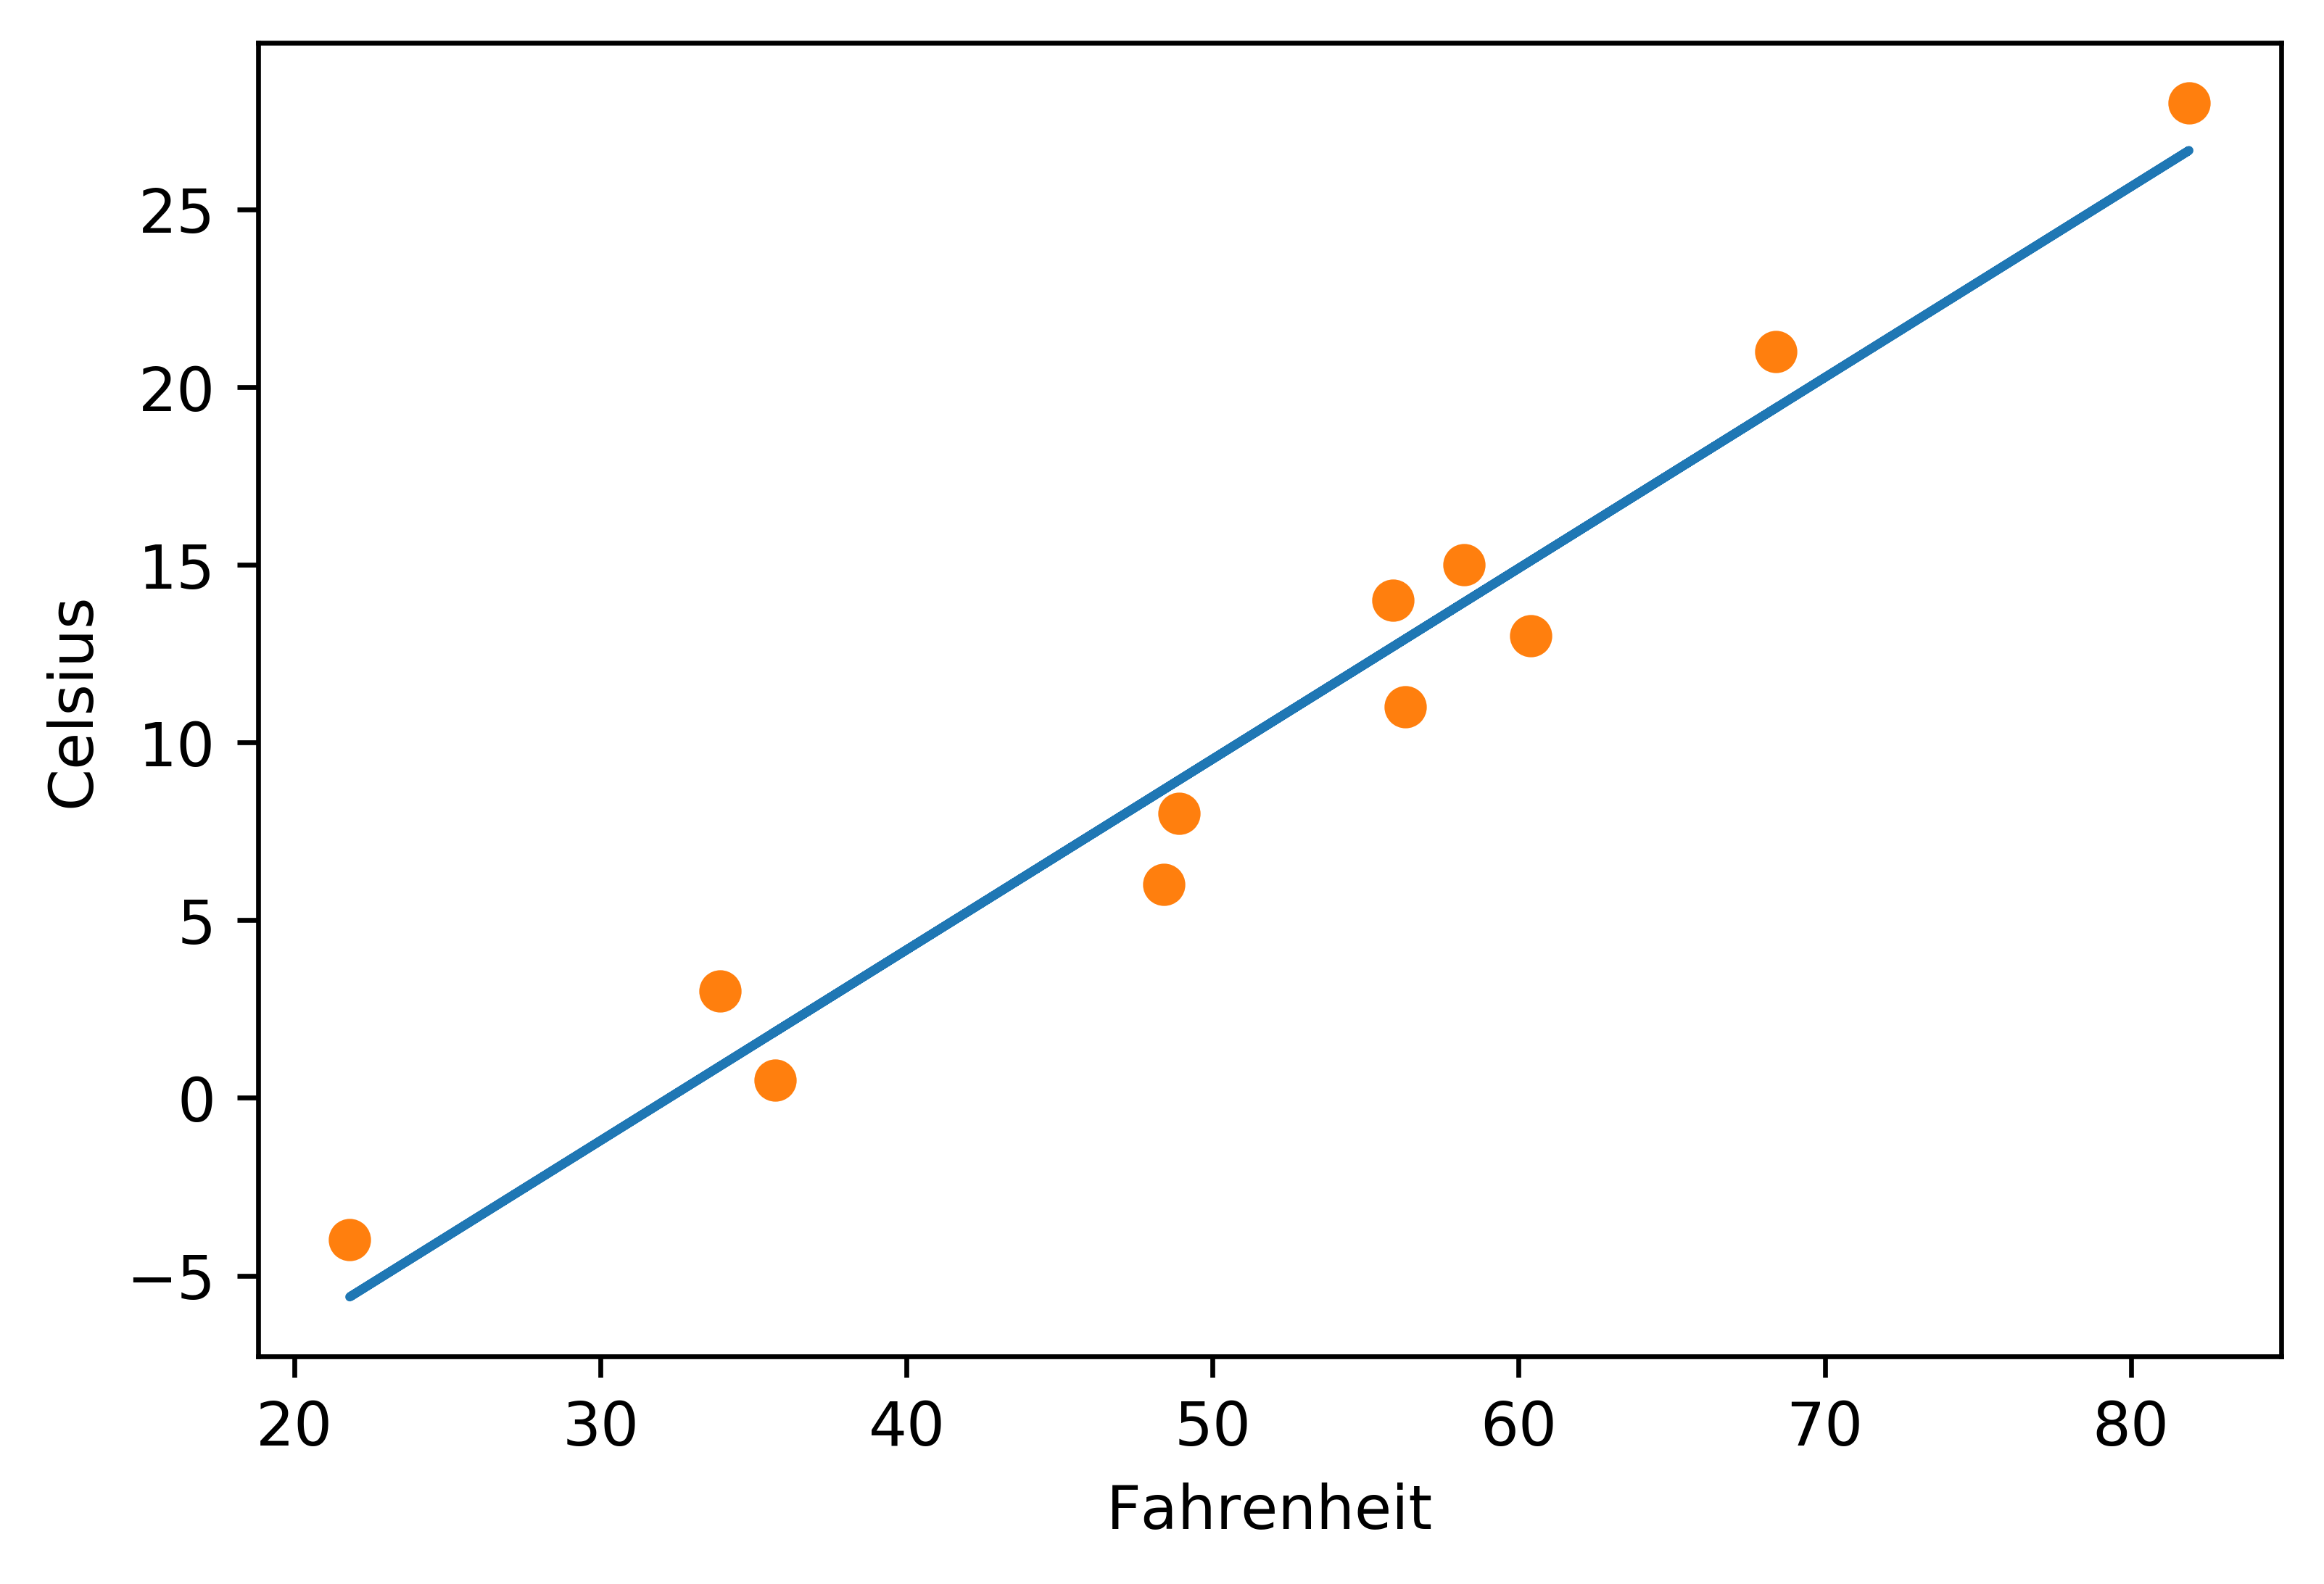

In [67]:
fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(),t_p.detach().numpy()) # while plotting use the raw
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
print('The plot of your linear-fit model (solid line) versus input data (circles)')